In [ ]:
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold


from sklearn.metrics import confusion_matrix , classification_report

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from joblib import dump,load
import requests,json
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import ClusterCentroids,NearMiss, RandomUnderSampler
from imblearn.combine import SMOTEENN,SMOTETomek

In [ ]:
sheet_url='https://docs.google.com/spreadsheets/d/1Tgwe3WNobCLzVSSRYxEQRYixBClAQxUmiC-dSsiYLQA/edit#gid=1098375213'
csv_export_url = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')

feature_table = pd.read_csv(csv_export_url)
#feature_table=feature_table.astype({'Label':'float'})
feature_table.head()


,FetchCommandType,UpdateCommandType,InsertCommandType,DeleteCommandType,detectSortClause,detectGroupByClause,detectWindowClause,detectWithRecursive,detectDistinctOn,detectLogicalOperator,detectArithmaticOperator,detectComparisonOperator,hasCompoundOperator,detectWindowFunc,detectAggregates,detectSetOperation,detectNumberOfWithClause,detectSubQuery,detectStringConstant,detectBackslash,detectNumber,detectDropKeyword,detectStoredProcedure,detectUtilityStmnt,Label
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,1,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1


In [ ]:
optimized_features= ['FetchCommandType','UpdateCommandType','InsertCommandType','DeleteCommandType','detectSortClause',
                     'detectWindowClause','detectComparisonOperator','detectSetOperation','detectNumberOfWithClause','detectStoredProcedure',
                     'detectLogicalOperator','detectArithmaticOperator','detectWindowFunc','detectSubQuery','detectStringConstant',
                     'detectBackslash','detectNumber']
print(len(optimized_features))
X[optimized_features]

17


,FetchCommandType,UpdateCommandType,InsertCommandType,DeleteCommandType,detectSortClause,detectWindowClause,detectComparisonOperator,detectSetOperation,detectNumberOfWithClause,detectStoredProcedure,detectLogicalOperator,detectArithmaticOperator,detectWindowFunc,detectSubQuery,detectStringConstant,detectBackslash,detectNumber
0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0
3,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,1,0
4,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30846,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0
30847,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
30848,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30849,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [ ]:
X = feature_table.drop(['Label'],axis='columns')
Y = feature_table['Label']

In [ ]:
model_params1 = {
    'svm': {
        'model': svm.SVC(gamma='auto',class_weight='balanced'),
        'params' : {
            'C': [1,10,20,30,40,45,50],
            'kernel': ['rbf','linear','poly']
        }  
    },
    'decision_tree': {
        'model': tree.DecisionTreeClassifier(class_weight='balanced'),
        'params' : {
            'criterion':["gini","entropy"],
            'max_depth':[1,2,3,4,5,6,7,None]
        }
    },
    'Adaboost':{
        'model':AdaBoostClassifier(base_estimator = tree.DecisionTreeClassifier(random_state = 11, max_features = "auto",max_depth = None,class_weight='balanced')),
        'params':{
              'base_estimator__criterion' : ["gini", "entropy"],
              'base_estimator__splitter' :   ["best", "random"],
              'n_estimators': [1, 2]
             }
    },
    
}

model_params2={
    'XGBoost':{
        'model': XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',silent=True, nthread=10) ,
        'params':{
            'min_child_weight': [1, 5, 10],
            'gamma': [0.5, 1, 1.5, 2, 5],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'max_depth': [3, 4, 5]
        }
    },
   
}
model_params3={
     'random_forest': {
        'model': RandomForestClassifier(class_weight = 'balanced'),
        'params' : {
            'n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto',class_weight = 'balanced'),
        'params': {
            'C': [1,5,10]
        }
    },
    'Naive_Bayes:BernoulliNB':{
        'model':BernoulliNB(),
        'params':{
            'alpha': [0.01, 0.1, 0.5, 1.0, 10.0],
        }
    },
}





In [17]:
def plot_loss_curve(clf):
    test_scores = clf.cv_results_['mean_test_score']
    train_scores = clf.cv_results_['mean_train_score'] 
    plt.plot(test_scores, label='test')
    plt.plot(train_scores, label='train')
    plt.legend(loc='best')
    plt.show()

In [18]:
def transform(transformer,x,y):
    print("Transforming {}".format(transformer.__class__.__name__))
    X_resampled,Y_resampled = transformer.fit_sample(x.values,y.values.ravel())
    return transformer.__class__.__name__,pd.DataFrame(X_resampled), pd.DataFrame(Y_resampled)


def launch_Grid_Search_Resampling(sampling_type,x,y,model_params):
    scores = []
    target_names = ['Not Malicious', 'Malicious']
    ConfusionMatrix={}

    for model_name, mp in model_params.items():
        grid =  GridSearchCV(estimator=mp['model'],param_grid= mp['params'],scoring='accuracy', 
                             cv=10,n_jobs=-1,verbose=2, return_train_score=True)
        clf = grid.fit(x, y)
        plot_loss_curve(clf)
        #getBestClassifierObject(model_name,sampling_type,grid)

        y_pred=grid.best_estimator_.predict(x)
        print('-------------------------------------------')
        print(model_name.upper())  
        print('-------------------------------------------')
        report=classification_report(y, y_pred, target_names=target_names,output_dict=True)
        print(report)
        ConfusionMatrix[model_name]  =  confusion_matrix(y, y_pred)
        
        macro_precision =  report['macro avg']['precision'] 
        macro_recall = report['macro avg']['recall']    
        macro_f1 = report['macro avg']['f1-score']    
        accuracy = report['accuracy']

        scores.append({
            'sampling_type':sampling_type,
            'model': model_name.upper(),
            'accuracy': accuracy,
            'precision':macro_precision,
            'recall':macro_recall,
            'f1_score':macro_f1,
            'best_params': grid.best_params_,    
        })      
    return scores






In [19]:
optimized_X=X[optimized_features]

datasets = []

datasets.append(transform(SMOTE(n_jobs=-1),optimized_X,Y))
datasets.append(transform(RandomOverSampler(),optimized_X,Y))
datasets.append(transform(NearMiss(n_jobs=-1),optimized_X,Y))
datasets.append(transform(RandomUnderSampler(),optimized_X,Y))
datasets.append(transform(SMOTEENN(),optimized_X,Y))
datasets.append(transform(SMOTETomek(),optimized_X,Y))





Transforming SMOTE


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Transforming RandomOverSampler
Transforming NearMiss


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Transforming RandomUnderSampler
Transforming SMOTEENN


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Transforming SMOTETomek


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


______________________________________________________________
SMOTE
Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 28.1min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed: 38.8min finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


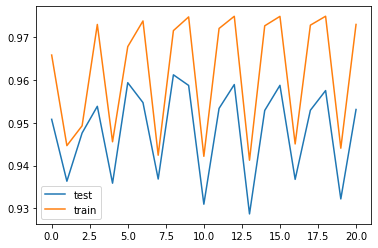

-------------------------------------------
SVM
-------------------------------------------
{'Not Malicious': {'precision': 0.9504213207916912, 'recall': 0.9930893268492449, 'f1-score': 0.9712869552156608, 'support': 19535}, 'Malicious': {'precision': 0.9927644978025512, 'recall': 0.9481955464550806, 'f1-score': 0.9699683188018746, 'support': 19535}, 'accuracy': 0.9706424366521628, 'macro avg': {'precision': 0.9715929092971212, 'recall': 0.9706424366521628, 'f1-score': 0.9706276370087676, 'support': 39070}, 'weighted avg': {'precision': 0.971592909297121, 'recall': 0.9706424366521628, 'f1-score': 0.9706276370087678, 'support': 39070}}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    6.6s finished


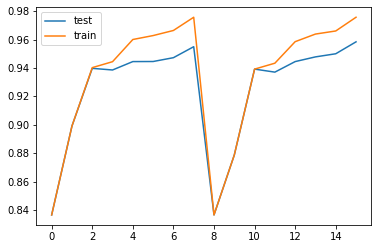

-------------------------------------------
DECISION_TREE
-------------------------------------------
{'Not Malicious': {'precision': 0.9632881085395052, 'recall': 0.9885845917583824, 'f1-score': 0.9757724275572848, 'support': 19535}, 'Malicious': {'precision': 0.9882767322048155, 'recall': 0.9623240337855132, 'f1-score': 0.9751277329667766, 'support': 19535}, 'accuracy': 0.9754543127719478, 'macro avg': {'precision': 0.9757824203721603, 'recall': 0.9754543127719478, 'f1-score': 0.9754500802620307, 'support': 39070}, 'weighted avg': {'precision': 0.9757824203721605, 'recall': 0.9754543127719478, 'f1-score': 0.9754500802620307, 'support': 39070}}
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    4.7s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


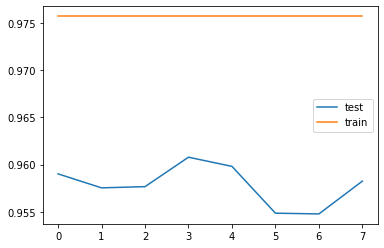

-------------------------------------------
ADABOOST
-------------------------------------------
{'Not Malicious': {'precision': 0.9632881085395052, 'recall': 0.9885845917583824, 'f1-score': 0.9757724275572848, 'support': 19535}, 'Malicious': {'precision': 0.9882767322048155, 'recall': 0.9623240337855132, 'f1-score': 0.9751277329667766, 'support': 19535}, 'accuracy': 0.9754543127719478, 'macro avg': {'precision': 0.9757824203721603, 'recall': 0.9754543127719478, 'f1-score': 0.9754500802620307, 'support': 39070}, 'weighted avg': {'precision': 0.9757824203721605, 'recall': 0.9754543127719478, 'f1-score': 0.9754500802620307, 'support': 39070}}
______________________________________________________________
______________________________________________________________
RandomOverSampler
Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 27.9min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed: 38.8min finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


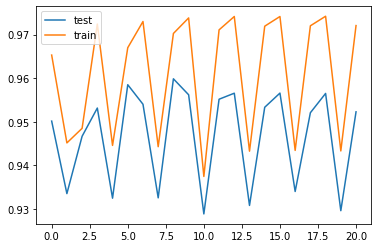

-------------------------------------------
SVM
-------------------------------------------
{'Not Malicious': {'precision': 0.9483770043019163, 'recall': 0.9930893268492449, 'f1-score': 0.9702182991173013, 'support': 19535}, 'Malicious': {'precision': 0.9927473944342967, 'recall': 0.9459431789096493, 'f1-score': 0.9687803087892213, 'support': 19535}, 'accuracy': 0.9695162528794471, 'macro avg': {'precision': 0.9705621993681065, 'recall': 0.9695162528794471, 'f1-score': 0.9694993039532613, 'support': 39070}, 'weighted avg': {'precision': 0.9705621993681064, 'recall': 0.9695162528794471, 'f1-score': 0.9694993039532613, 'support': 39070}}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    6.1s finished


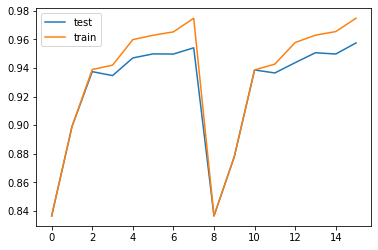

-------------------------------------------
DECISION_TREE
-------------------------------------------
{'Not Malicious': {'precision': 0.9610564010743062, 'recall': 0.9891476836447403, 'f1-score': 0.9748997250321637, 'support': 19535}, 'Malicious': {'precision': 0.9888209238557266, 'recall': 0.9599180957256207, 'f1-score': 0.9741551728616327, 'support': 19535}, 'accuracy': 0.9745328896851805, 'macro avg': {'precision': 0.9749386624650165, 'recall': 0.9745328896851805, 'f1-score': 0.9745274489468982, 'support': 39070}, 'weighted avg': {'precision': 0.9749386624650165, 'recall': 0.9745328896851805, 'f1-score': 0.9745274489468981, 'support': 39070}}
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    4.8s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


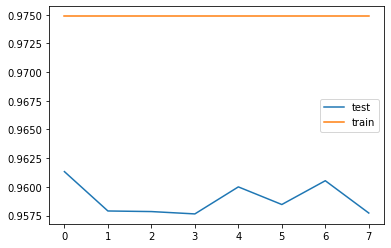

-------------------------------------------
ADABOOST
-------------------------------------------
{'Not Malicious': {'precision': 0.9610564010743062, 'recall': 0.9891476836447403, 'f1-score': 0.9748997250321637, 'support': 19535}, 'Malicious': {'precision': 0.9888209238557266, 'recall': 0.9599180957256207, 'f1-score': 0.9741551728616327, 'support': 19535}, 'accuracy': 0.9745328896851805, 'macro avg': {'precision': 0.9749386624650165, 'recall': 0.9745328896851805, 'f1-score': 0.9745274489468982, 'support': 39070}, 'weighted avg': {'precision': 0.9749386624650165, 'recall': 0.9745328896851805, 'f1-score': 0.9745274489468981, 'support': 39070}}
______________________________________________________________
______________________________________________________________
NearMiss
Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed: 11.7min finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


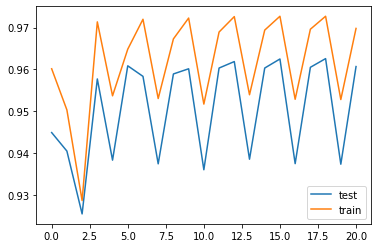

-------------------------------------------
SVM
-------------------------------------------
{'Not Malicious': {'precision': 0.9573921971252567, 'recall': 0.9888653234358431, 'f1-score': 0.9728742827334377, 'support': 11316}, 'Malicious': {'precision': 0.9884868421052632, 'recall': 0.9559915164369035, 'f1-score': 0.9719676549865228, 'support': 11316}, 'accuracy': 0.9724284199363733, 'macro avg': {'precision': 0.9729395196152599, 'recall': 0.9724284199363733, 'f1-score': 0.9724209688599803, 'support': 22632}, 'weighted avg': {'precision': 0.9729395196152599, 'recall': 0.9724284199363733, 'f1-score': 0.9724209688599802, 'support': 22632}}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    3.5s finished


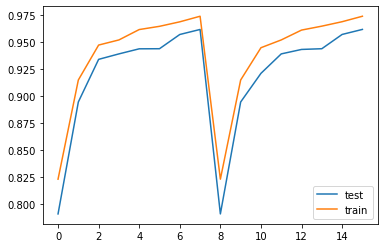

-------------------------------------------
DECISION_TREE
-------------------------------------------
{'Not Malicious': {'precision': 0.9587187392942789, 'recall': 0.9892188052315306, 'f1-score': 0.9737299930410578, 'support': 11316}, 'Malicious': {'precision': 0.9888645491055129, 'recall': 0.9574054436196536, 'f1-score': 0.9728807471264368, 'support': 11316}, 'accuracy': 0.9733121244255921, 'macro avg': {'precision': 0.973791644199896, 'recall': 0.9733121244255921, 'f1-score': 0.9733053700837473, 'support': 22632}, 'weighted avg': {'precision': 0.973791644199896, 'recall': 0.9733121244255921, 'f1-score': 0.9733053700837474, 'support': 22632}}
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    2.9s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


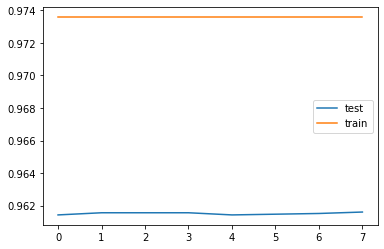

-------------------------------------------
ADABOOST
-------------------------------------------
{'Not Malicious': {'precision': 0.9587187392942789, 'recall': 0.9892188052315306, 'f1-score': 0.9737299930410578, 'support': 11316}, 'Malicious': {'precision': 0.9888645491055129, 'recall': 0.9574054436196536, 'f1-score': 0.9728807471264368, 'support': 11316}, 'accuracy': 0.9733121244255921, 'macro avg': {'precision': 0.973791644199896, 'recall': 0.9733121244255921, 'f1-score': 0.9733053700837473, 'support': 22632}, 'weighted avg': {'precision': 0.973791644199896, 'recall': 0.9733121244255921, 'f1-score': 0.9733053700837474, 'support': 22632}}
______________________________________________________________
______________________________________________________________
RandomUnderSampler
Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed: 14.0min finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


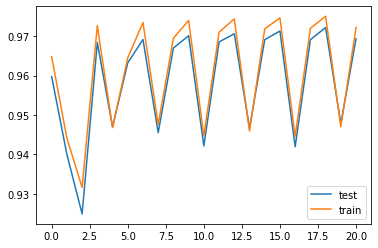

-------------------------------------------
SVM
-------------------------------------------
{'Not Malicious': {'precision': 0.9613634412295011, 'recall': 0.9894839165782963, 'f1-score': 0.9752210077080521, 'support': 11316}, 'Malicious': {'precision': 0.9891670459717797, 'recall': 0.9602332979851538, 'f1-score': 0.9744854490830009, 'support': 11316}, 'accuracy': 0.974858607281725, 'macro avg': {'precision': 0.9752652436006404, 'recall': 0.974858607281725, 'f1-score': 0.9748532283955265, 'support': 22632}, 'weighted avg': {'precision': 0.9752652436006405, 'recall': 0.974858607281725, 'f1-score': 0.9748532283955265, 'support': 22632}}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    3.8s finished


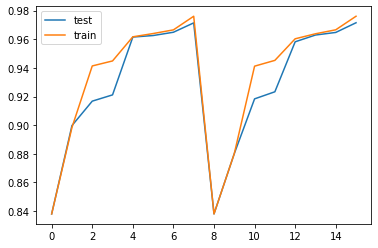

-------------------------------------------
DECISION_TREE
-------------------------------------------
{'Not Malicious': {'precision': 0.9630330123796423, 'recall': 0.9899257688229056, 'f1-score': 0.9762942304340247, 'support': 11316}, 'Malicious': {'precision': 0.9896363636363636, 'recall': 0.9620007069635914, 'f1-score': 0.9756228714823445, 'support': 11316}, 'accuracy': 0.9759632378932485, 'macro avg': {'precision': 0.976334688008003, 'recall': 0.9759632378932486, 'f1-score': 0.9759585509581846, 'support': 22632}, 'weighted avg': {'precision': 0.976334688008003, 'recall': 0.9759632378932485, 'f1-score': 0.9759585509581847, 'support': 22632}}
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    3.0s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


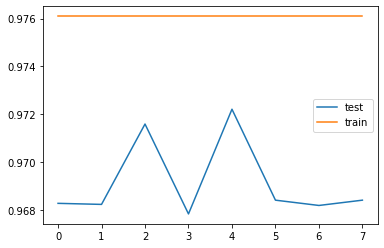

-------------------------------------------
ADABOOST
-------------------------------------------
{'Not Malicious': {'precision': 0.9630330123796423, 'recall': 0.9899257688229056, 'f1-score': 0.9762942304340247, 'support': 11316}, 'Malicious': {'precision': 0.9896363636363636, 'recall': 0.9620007069635914, 'f1-score': 0.9756228714823445, 'support': 11316}, 'accuracy': 0.9759632378932485, 'macro avg': {'precision': 0.976334688008003, 'recall': 0.9759632378932486, 'f1-score': 0.9759585509581846, 'support': 22632}, 'weighted avg': {'precision': 0.976334688008003, 'recall': 0.9759632378932485, 'f1-score': 0.9759585509581847, 'support': 22632}}
______________________________________________________________
______________________________________________________________
SMOTEENN
Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed: 13.2min finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


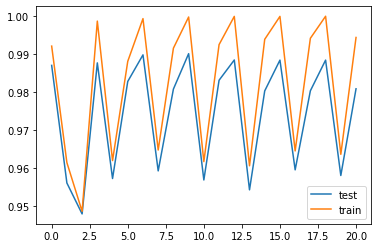

-------------------------------------------
SVM
-------------------------------------------
{'Not Malicious': {'precision': 0.9996877601998335, 'recall': 0.9996877601998335, 'f1-score': 0.9996877601998335, 'support': 9608}, 'Malicious': {'precision': 0.9998446963814257, 'recall': 0.9998446963814257, 'f1-score': 0.9998446963814257, 'support': 19317}, 'accuracy': 0.9997925669835782, 'macro avg': {'precision': 0.9997662282906297, 'recall': 0.9997662282906297, 'f1-score': 0.9997662282906297, 'support': 28925}, 'weighted avg': {'precision': 0.9997925669835782, 'recall': 0.9997925669835782, 'f1-score': 0.9997925669835782, 'support': 28925}}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    4.6s finished


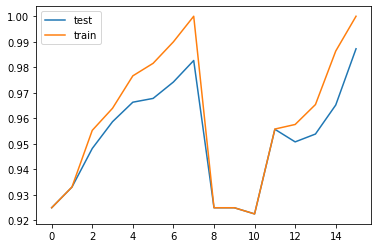

-------------------------------------------
DECISION_TREE
-------------------------------------------
{'Not Malicious': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 9608}, 'Malicious': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 19317}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 28925}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 28925}}
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    2.5s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


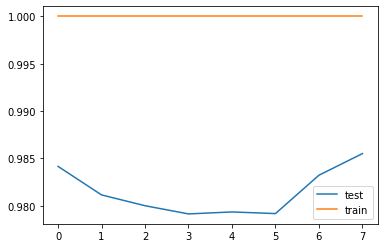

-------------------------------------------
ADABOOST
-------------------------------------------
{'Not Malicious': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 9608}, 'Malicious': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 19317}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 28925}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 28925}}
______________________________________________________________
______________________________________________________________
SMOTETomek
Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 26.9min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed: 37.6min finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


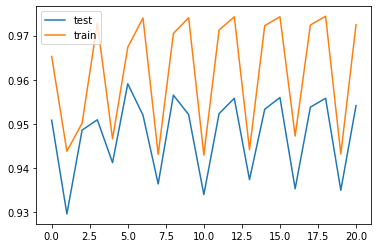

-------------------------------------------
SVM
-------------------------------------------
{'Not Malicious': {'precision': 0.9475510802620002, 'recall': 0.9923214742769388, 'f1-score': 0.9694196484384767, 'support': 19535}, 'Malicious': {'precision': 0.9919406834300452, 'recall': 0.9450729459943691, 'f1-score': 0.967939811780743, 'support': 19535}, 'accuracy': 0.9686972101356539, 'macro avg': {'precision': 0.9697458818460227, 'recall': 0.9686972101356539, 'f1-score': 0.9686797301096098, 'support': 39070}, 'weighted avg': {'precision': 0.9697458818460225, 'recall': 0.9686972101356539, 'f1-score': 0.96867973010961, 'support': 39070}}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    6.2s finished


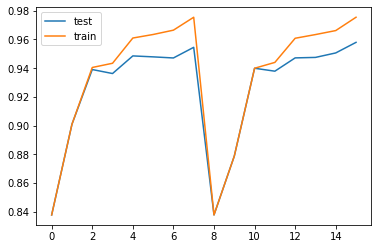

-------------------------------------------
DECISION_TREE
-------------------------------------------
{'Not Malicious': {'precision': 0.9627118644067797, 'recall': 0.9885845917583824, 'f1-score': 0.9754767016037379, 'support': 19535}, 'Malicious': {'precision': 0.9882693319305629, 'recall': 0.9617097517276683, 'f1-score': 0.9748086651965235, 'support': 19535}, 'accuracy': 0.9751471717430253, 'macro avg': {'precision': 0.9754905981686712, 'recall': 0.9751471717430253, 'f1-score': 0.9751426834001307, 'support': 39070}, 'weighted avg': {'precision': 0.9754905981686712, 'recall': 0.9751471717430253, 'f1-score': 0.9751426834001309, 'support': 39070}}
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    5.0s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


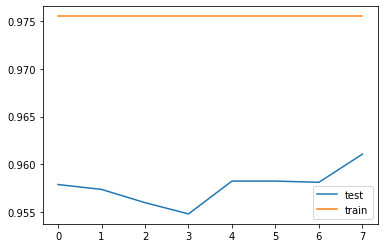

-------------------------------------------
ADABOOST
-------------------------------------------
{'Not Malicious': {'precision': 0.9628041483845233, 'recall': 0.9884822114154083, 'f1-score': 0.9754742239397842, 'support': 19535}, 'Malicious': {'precision': 0.9881666140738403, 'recall': 0.9618121320706424, 'f1-score': 0.97481127915121, 'support': 19535}, 'accuracy': 0.9751471717430253, 'macro avg': {'precision': 0.9754853812291818, 'recall': 0.9751471717430253, 'f1-score': 0.9751427515454971, 'support': 39070}, 'weighted avg': {'precision': 0.9754853812291817, 'recall': 0.9751471717430253, 'f1-score': 0.9751427515454971, 'support': 39070}}
______________________________________________________________


In [20]:
benchmark_scores1 = []
for sample_type,x,y in datasets:
    print('______________________________________________________________')
    print('{}'.format(sample_type))
    benchmark_scores1 = benchmark_scores1 + (launch_Grid_Search_Resampling(sample_type,x,y,model_params1))
    print('______________________________________________________________')



In [21]:
print(benchmark_scores1)
sampling_results = pd.DataFrame(benchmark_scores1,columns=['sampling_type','model','accuracy','precision','recall','f1_score','best_params'])
sampling_results.to_csv("report1(with_resampling).csv")
sampling_results

[{'sampling_type': 'SMOTE', 'model': 'SVM', 'accuracy': 0.9706424366521628, 'precision': 0.9715929092971212, 'recall': 0.9706424366521628, 'f1_score': 0.9706276370087676, 'best_params': {'C': 20, 'kernel': 'poly'}}, {'sampling_type': 'SMOTE', 'model': 'DECISION_TREE', 'accuracy': 0.9754543127719478, 'precision': 0.9757824203721603, 'recall': 0.9754543127719478, 'f1_score': 0.9754500802620307, 'best_params': {'criterion': 'entropy', 'max_depth': None}}, {'sampling_type': 'SMOTE', 'model': 'ADABOOST', 'accuracy': 0.9754543127719478, 'precision': 0.9757824203721603, 'recall': 0.9754543127719478, 'f1_score': 0.9754500802620307, 'best_params': {'base_estimator__criterion': 'gini', 'base_estimator__splitter': 'random', 'n_estimators': 2}}, {'sampling_type': 'RandomOverSampler', 'model': 'SVM', 'accuracy': 0.9695162528794471, 'precision': 0.9705621993681065, 'recall': 0.9695162528794471, 'f1_score': 0.9694993039532613, 'best_params': {'C': 20, 'kernel': 'poly'}}, {'sampling_type': 'RandomOver

,sampling_type,model,accuracy,precision,recall,f1_score,best_params
0,SMOTE,SVM,0.970642,0.971593,0.970642,0.970628,"{'C': 20, 'kernel': 'poly'}"
1,SMOTE,DECISION_TREE,0.975454,0.975782,0.975454,0.975450,"{'criterion': 'entropy', 'max_depth': None}"
2,SMOTE,ADABOOST,0.975454,0.975782,0.975454,0.975450,"{'base_estimator__criterion': 'gini', 'base_es..."
3,RandomOverSampler,SVM,0.969516,0.970562,0.969516,0.969499,"{'C': 20, 'kernel': 'poly'}"
4,RandomOverSampler,DECISION_TREE,0.974533,0.974939,0.974533,0.974527,"{'criterion': 'entropy', 'max_depth': None}"
5,RandomOverSampler,ADABOOST,0.974533,0.974939,0.974533,0.974527,"{'base_estimator__criterion': 'gini', 'base_es..."
6,NearMiss,SVM,0.972428,0.972940,0.972428,0.972421,"{'C': 50, 'kernel': 'rbf'}"
7,NearMiss,DECISION_TREE,0.973312,0.973792,0.973312,0.973305,"{'criterion': 'entropy', 'max_depth': None}"
8,NearMiss,ADABOOST,0.973312,0.973792,0.973312,0.973305,"{'base_estimator__criterion': 'entropy', 'base..."
9,RandomUnderSampler,SVM,0.974859,0.975265,0.974859,0.974853,"{'C': 50, 'kernel': 'rbf'}"


______________________________________________________________
SMOTE
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.0s finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


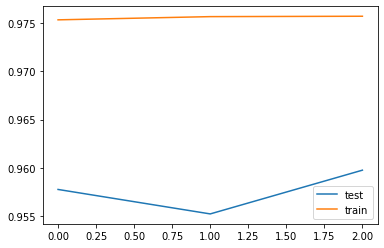

-------------------------------------------
RANDOM_FOREST
-------------------------------------------
{'Not Malicious': {'precision': 0.9631920199501247, 'recall': 0.9885845917583824, 'f1-score': 0.9757231274472654, 'support': 19535}, 'Malicious': {'precision': 0.9882754994742377, 'recall': 0.9622216534425391, 'f1-score': 0.9750745687978214, 'support': 19535}, 'accuracy': 0.9754031226004607, 'macro avg': {'precision': 0.9757337597121811, 'recall': 0.9754031226004607, 'f1-score': 0.9753988481225434, 'support': 39070}, 'weighted avg': {'precision': 0.9757337597121812, 'recall': 0.9754031226004607, 'f1-score': 0.9753988481225434, 'support': 39070}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.9s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


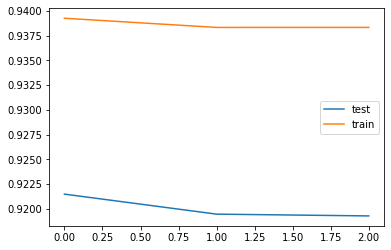

-------------------------------------------
LOGISTIC_REGRESSION
-------------------------------------------
{'Not Malicious': {'precision': 0.9439933374973974, 'recall': 0.9283849500895828, 'f1-score': 0.9361240870260923, 'support': 19535}, 'Malicious': {'precision': 0.9295498036055998, 'recall': 0.9449193754799079, 'f1-score': 0.937171578706877, 'support': 19535}, 'accuracy': 0.9366521627847453, 'macro avg': {'precision': 0.9367715705514986, 'recall': 0.9366521627847453, 'f1-score': 0.9366478328664847, 'support': 39070}, 'weighted avg': {'precision': 0.9367715705514986, 'recall': 0.9366521627847453, 'f1-score': 0.9366478328664846, 'support': 39070}}
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.6s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


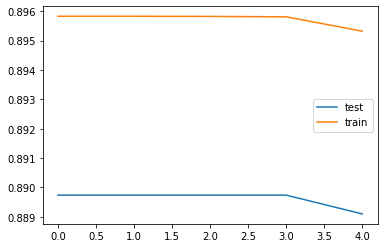

-------------------------------------------
NAIVE_BAYES:BERNOULLINB
-------------------------------------------
{'Not Malicious': {'precision': 0.9247340711292575, 'recall': 0.881136421807013, 'f1-score': 0.9024089753335606, 'support': 19535}, 'Malicious': {'precision': 0.8864880719593273, 'recall': 0.9282825697466086, 'f1-score': 0.9069040534120177, 'support': 19535}, 'accuracy': 0.9047094957768108, 'macro avg': {'precision': 0.9056110715442924, 'recall': 0.9047094957768108, 'f1-score': 0.9046565143727892, 'support': 39070}, 'weighted avg': {'precision': 0.9056110715442924, 'recall': 0.9047094957768108, 'f1-score': 0.9046565143727892, 'support': 39070}}
______________________________________________________________
______________________________________________________________
RandomOverSampler
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.9s finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


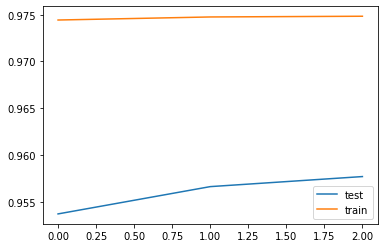

-------------------------------------------
RANDOM_FOREST
-------------------------------------------
{'Not Malicious': {'precision': 0.9615135673388101, 'recall': 0.9885845917583824, 'f1-score': 0.9748611812216053, 'support': 19535}, 'Malicious': {'precision': 0.988253884645773, 'recall': 0.9604299974404914, 'f1-score': 0.9741433021806853, 'support': 19535}, 'accuracy': 0.9745072945994369, 'macro avg': {'precision': 0.9748837259922916, 'recall': 0.9745072945994369, 'f1-score': 0.9745022417011453, 'support': 39070}, 'weighted avg': {'precision': 0.9748837259922916, 'recall': 0.9745072945994369, 'f1-score': 0.9745022417011454, 'support': 39070}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.8s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


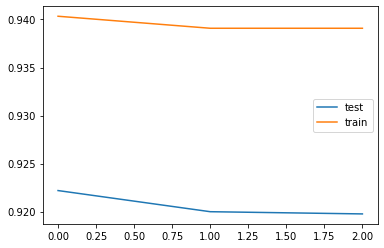

-------------------------------------------
LOGISTIC_REGRESSION
-------------------------------------------
{'Not Malicious': {'precision': 0.9428645697946452, 'recall': 0.9283849500895828, 'f1-score': 0.9355687387155017, 'support': 19535}, 'Malicious': {'precision': 0.9294681119233678, 'recall': 0.9437420015357052, 'f1-score': 0.9365506731013462, 'support': 19535}, 'accuracy': 0.9360634758126439, 'macro avg': {'precision': 0.9361663408590064, 'recall': 0.936063475812644, 'f1-score': 0.9360597059084239, 'support': 39070}, 'weighted avg': {'precision': 0.9361663408590065, 'recall': 0.9360634758126439, 'f1-score': 0.936059705908424, 'support': 39070}}
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.7s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


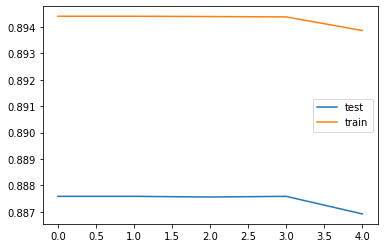

-------------------------------------------
NAIVE_BAYES:BERNOULLINB
-------------------------------------------
{'Not Malicious': {'precision': 0.9228500965043963, 'recall': 0.881136421807013, 'f1-score': 0.9015109854138842, 'support': 19535}, 'Malicious': {'precision': 0.8862768145753747, 'recall': 0.9263373432300999, 'f1-score': 0.9058643906590245, 'support': 19535}, 'accuracy': 0.9037368825185564, 'macro avg': {'precision': 0.9045634555398855, 'recall': 0.9037368825185564, 'f1-score': 0.9036876880364544, 'support': 39070}, 'weighted avg': {'precision': 0.9045634555398855, 'recall': 0.9037368825185564, 'f1-score': 0.9036876880364542, 'support': 39070}}
______________________________________________________________
______________________________________________________________
NearMiss
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.7s finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


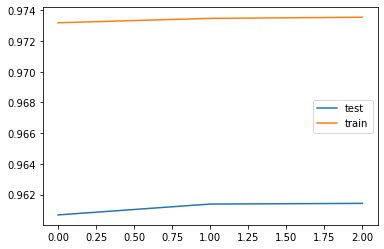

-------------------------------------------
RANDOM_FOREST
-------------------------------------------
{'Not Malicious': {'precision': 0.9587187392942789, 'recall': 0.9892188052315306, 'f1-score': 0.9737299930410578, 'support': 11316}, 'Malicious': {'precision': 0.9888645491055129, 'recall': 0.9574054436196536, 'f1-score': 0.9728807471264368, 'support': 11316}, 'accuracy': 0.9733121244255921, 'macro avg': {'precision': 0.973791644199896, 'recall': 0.9733121244255921, 'f1-score': 0.9733053700837473, 'support': 22632}, 'weighted avg': {'precision': 0.973791644199896, 'recall': 0.9733121244255921, 'f1-score': 0.9733053700837474, 'support': 22632}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.4s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


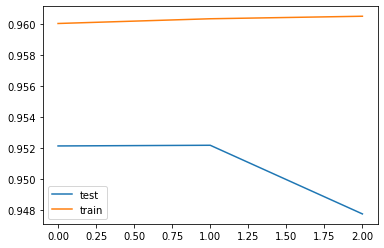

-------------------------------------------
LOGISTIC_REGRESSION
-------------------------------------------
{'Not Malicious': {'precision': 0.9570611526616806, 'recall': 0.9612053729232944, 'f1-score': 0.9591287862087209, 'support': 11316}, 'Malicious': {'precision': 0.961036655720245, 'recall': 0.9568752209261223, 'f1-score': 0.9589514236372494, 'support': 11316}, 'accuracy': 0.9590402969247084, 'macro avg': {'precision': 0.9590489041909628, 'recall': 0.9590402969247084, 'f1-score': 0.9590401049229851, 'support': 22632}, 'weighted avg': {'precision': 0.9590489041909629, 'recall': 0.9590402969247084, 'f1-score': 0.9590401049229852, 'support': 22632}}
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.0s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


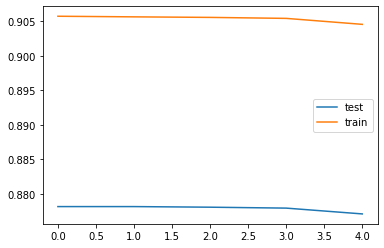

-------------------------------------------
NAIVE_BAYES:BERNOULLINB
-------------------------------------------
{'Not Malicious': {'precision': 0.9233504543658633, 'recall': 0.8260869565217391, 'f1-score': 0.8720149253731343, 'support': 11316}, 'Malicious': {'precision': 0.8426606971538215, 'recall': 0.9314245316366208, 'f1-score': 0.8848220282068503, 'support': 11316}, 'accuracy': 0.8787557440791799, 'macro avg': {'precision': 0.8830055757598424, 'recall': 0.87875574407918, 'f1-score': 0.8784184767899923, 'support': 22632}, 'weighted avg': {'precision': 0.8830055757598423, 'recall': 0.8787557440791799, 'f1-score': 0.8784184767899922, 'support': 22632}}
______________________________________________________________
______________________________________________________________
RandomUnderSampler
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.7s finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


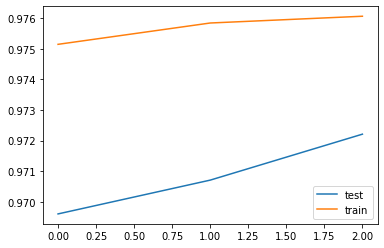

-------------------------------------------
RANDOM_FOREST
-------------------------------------------
{'Not Malicious': {'precision': 0.9630330123796423, 'recall': 0.9899257688229056, 'f1-score': 0.9762942304340247, 'support': 11316}, 'Malicious': {'precision': 0.9896363636363636, 'recall': 0.9620007069635914, 'f1-score': 0.9756228714823445, 'support': 11316}, 'accuracy': 0.9759632378932485, 'macro avg': {'precision': 0.976334688008003, 'recall': 0.9759632378932486, 'f1-score': 0.9759585509581846, 'support': 22632}, 'weighted avg': {'precision': 0.976334688008003, 'recall': 0.9759632378932485, 'f1-score': 0.9759585509581847, 'support': 22632}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.8s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


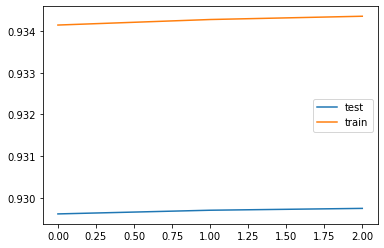

-------------------------------------------
LOGISTIC_REGRESSION
-------------------------------------------
{'Not Malicious': {'precision': 0.9277055516514406, 'recall': 0.9332803110639802, 'f1-score': 0.9304845814977974, 'support': 11316}, 'Malicious': {'precision': 0.9328769559032717, 'recall': 0.9272711205372923, 'f1-score': 0.9300655912072328, 'support': 11316}, 'accuracy': 0.9302757158006363, 'macro avg': {'precision': 0.9302912537773562, 'recall': 0.9302757158006363, 'f1-score': 0.9302750863525151, 'support': 22632}, 'weighted avg': {'precision': 0.9302912537773562, 'recall': 0.9302757158006363, 'f1-score': 0.9302750863525151, 'support': 22632}}
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


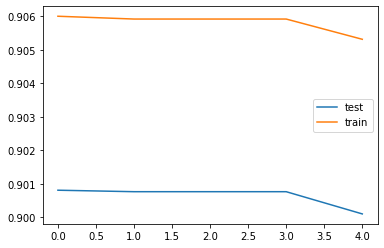

-------------------------------------------
NAIVE_BAYES:BERNOULLINB
-------------------------------------------
{'Not Malicious': {'precision': 0.9254974548819991, 'recall': 0.8837044892188052, 'f1-score': 0.9041182586682338, 'support': 11316}, 'Malicious': {'precision': 0.8887291789972098, 'recall': 0.9288617886178862, 'f1-score': 0.9083524175776693, 'support': 11316}, 'accuracy': 0.9062831389183457, 'macro avg': {'precision': 0.9071133169396044, 'recall': 0.9062831389183457, 'f1-score': 0.9062353381229515, 'support': 22632}, 'weighted avg': {'precision': 0.9071133169396044, 'recall': 0.9062831389183457, 'f1-score': 0.9062353381229515, 'support': 22632}}
______________________________________________________________
______________________________________________________________
SMOTEENN
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.0s finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


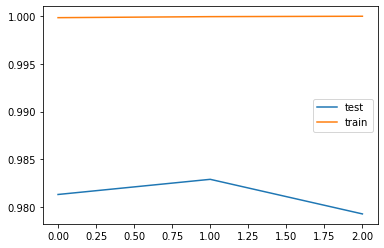

-------------------------------------------
RANDOM_FOREST
-------------------------------------------
{'Not Malicious': {'precision': 1.0, 'recall': 0.9998959200666112, 'f1-score': 0.9999479573250065, 'support': 9608}, 'Malicious': {'precision': 0.9999482348069159, 'recall': 1.0, 'f1-score': 0.9999741167335318, 'support': 19317}, 'accuracy': 0.9999654278305964, 'macro avg': {'precision': 0.999974117403458, 'recall': 0.9999479600333057, 'f1-score': 0.9999610370292691, 'support': 28925}, 'weighted avg': {'precision': 0.9999654296202314, 'recall': 0.9999654278305964, 'f1-score': 0.9999654273784025, 'support': 28925}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.1s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


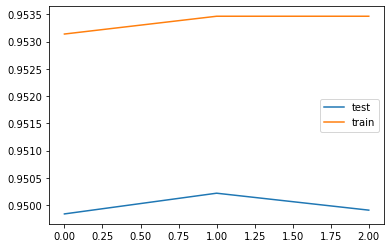

-------------------------------------------
LOGISTIC_REGRESSION
-------------------------------------------
{'Not Malicious': {'precision': 0.8981401175676977, 'recall': 0.9700249791840133, 'f1-score': 0.9326995246434826, 'support': 9608}, 'Malicious': {'precision': 0.9844727194306664, 'recall': 0.9452813583889838, 'f1-score': 0.9644790703816188, 'support': 19317}, 'accuracy': 0.9535004321521175, 'macro avg': {'precision': 0.9413064184991821, 'recall': 0.9576531687864985, 'f1-score': 0.9485892975125507, 'support': 28925}, 'weighted avg': {'precision': 0.9557956705560111, 'recall': 0.9535004321521175, 'f1-score': 0.9539228776261474, 'support': 28925}}
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


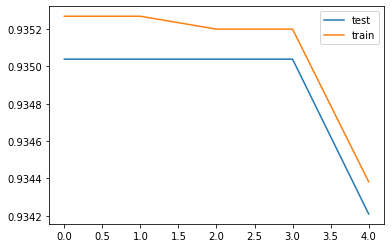

-------------------------------------------
NAIVE_BAYES:BERNOULLINB
-------------------------------------------
{'Not Malicious': {'precision': 0.8997312383708911, 'recall': 0.9059117402164862, 'f1-score': 0.9028109117311482, 'support': 9608}, 'Malicious': {'precision': 0.95304140044673, 'recall': 0.9497851633276388, 'f1-score': 0.9514104957477701, 'support': 19317}, 'accuracy': 0.9352117545375972, 'macro avg': {'precision': 0.9263863194088106, 'recall': 0.9278484517720625, 'f1-score': 0.9271107037394593, 'support': 28925}, 'weighted avg': {'precision': 0.9353333957025758, 'recall': 0.9352117545375972, 'f1-score': 0.9352672009082991, 'support': 28925}}
______________________________________________________________
______________________________________________________________
SMOTETomek
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:    2.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.9s finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


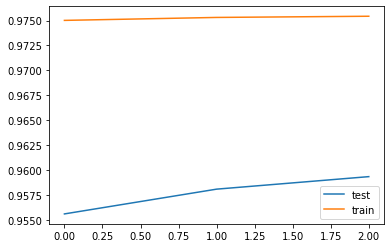

-------------------------------------------
RANDOM_FOREST
-------------------------------------------
{'Not Malicious': {'precision': 0.9643232424318239, 'recall': 0.9865369848988994, 'f1-score': 0.9753036437246964, 'support': 19535}, 'Malicious': {'precision': 0.9862195441446162, 'recall': 0.9635014077297159, 'f1-score': 0.9747281201450027, 'support': 19535}, 'accuracy': 0.9750191963143077, 'macro avg': {'precision': 0.97527139328822, 'recall': 0.9750191963143077, 'f1-score': 0.9750158819348496, 'support': 39070}, 'weighted avg': {'precision': 0.97527139328822, 'recall': 0.9750191963143077, 'f1-score': 0.9750158819348496, 'support': 39070}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.8s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


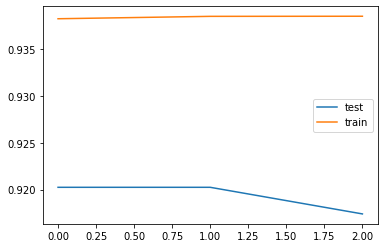

-------------------------------------------
LOGISTIC_REGRESSION
-------------------------------------------
{'Not Malicious': {'precision': 0.9285020698114171, 'recall': 0.9300230355771691, 'f1-score': 0.9292619303360442, 'support': 19535}, 'Malicious': {'precision': 0.9299082192483208, 'recall': 0.9283849500895828, 'f1-score': 0.9291459603463292, 'support': 19535}, 'accuracy': 0.929203992833376, 'macro avg': {'precision': 0.929205144529869, 'recall': 0.929203992833376, 'f1-score': 0.9292039453411867, 'support': 39070}, 'weighted avg': {'precision': 0.9292051445298689, 'recall': 0.929203992833376, 'f1-score': 0.9292039453411868, 'support': 39070}}
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.7s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


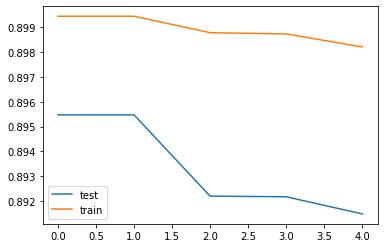

-------------------------------------------
NAIVE_BAYES:BERNOULLINB
-------------------------------------------
{'Not Malicious': {'precision': 0.9266756393001346, 'recall': 0.881136421807013, 'f1-score': 0.9033324586722646, 'support': 19535}, 'Malicious': {'precision': 0.8867040741644303, 'recall': 0.9302789864346046, 'f1-score': 0.9079690232325757, 'support': 19535}, 'accuracy': 0.9057077041208088, 'macro avg': {'precision': 0.9066898567322825, 'recall': 0.9057077041208088, 'f1-score': 0.9056507409524202, 'support': 39070}, 'weighted avg': {'precision': 0.9066898567322825, 'recall': 0.9057077041208088, 'f1-score': 0.90565074095242, 'support': 39070}}
______________________________________________________________


In [22]:
benchmark_scores3 = []
for sample_type,x,y in datasets:
    print('______________________________________________________________')
    print('{}'.format(sample_type))
    benchmark_scores3 = benchmark_scores3 + (launch_Grid_Search_Resampling(sample_type,x,y,model_params3))
    print('______________________________________________________________')



In [23]:
print(benchmark_scores3)
sampling_results = pd.DataFrame(benchmark_scores3,columns=['sampling_type','model','accuracy','precision','recall','f1_score','best_params'])
sampling_results.to_csv("report3(with_resampling).csv")
sampling_results

[{'sampling_type': 'SMOTE', 'model': 'RANDOM_FOREST', 'accuracy': 0.9754031226004607, 'precision': 0.9757337597121811, 'recall': 0.9754031226004607, 'f1_score': 0.9753988481225434, 'best_params': {'n_estimators': 10}}, {'sampling_type': 'SMOTE', 'model': 'LOGISTIC_REGRESSION', 'accuracy': 0.9366521627847453, 'precision': 0.9367715705514986, 'recall': 0.9366521627847453, 'f1_score': 0.9366478328664847, 'best_params': {'C': 1}}, {'sampling_type': 'SMOTE', 'model': 'NAIVE_BAYES:BERNOULLINB', 'accuracy': 0.9047094957768108, 'precision': 0.9056110715442924, 'recall': 0.9047094957768108, 'f1_score': 0.9046565143727892, 'best_params': {'alpha': 0.01}}, {'sampling_type': 'RandomOverSampler', 'model': 'RANDOM_FOREST', 'accuracy': 0.9745072945994369, 'precision': 0.9748837259922916, 'recall': 0.9745072945994369, 'f1_score': 0.9745022417011453, 'best_params': {'n_estimators': 10}}, {'sampling_type': 'RandomOverSampler', 'model': 'LOGISTIC_REGRESSION', 'accuracy': 0.9360634758126439, 'precision': 

,sampling_type,model,accuracy,precision,recall,f1_score,best_params
0,SMOTE,RANDOM_FOREST,0.975403,0.975734,0.975403,0.975399,{'n_estimators': 10}
1,SMOTE,LOGISTIC_REGRESSION,0.936652,0.936772,0.936652,0.936648,{'C': 1}
2,SMOTE,NAIVE_BAYES:BERNOULLINB,0.904709,0.905611,0.904709,0.904657,{'alpha': 0.01}
3,RandomOverSampler,RANDOM_FOREST,0.974507,0.974884,0.974507,0.974502,{'n_estimators': 10}
4,RandomOverSampler,LOGISTIC_REGRESSION,0.936063,0.936166,0.936063,0.936060,{'C': 1}
5,RandomOverSampler,NAIVE_BAYES:BERNOULLINB,0.903737,0.904563,0.903737,0.903688,{'alpha': 0.01}
6,NearMiss,RANDOM_FOREST,0.973312,0.973792,0.973312,0.973305,{'n_estimators': 10}
7,NearMiss,LOGISTIC_REGRESSION,0.959040,0.959049,0.959040,0.959040,{'C': 5}
8,NearMiss,NAIVE_BAYES:BERNOULLINB,0.878756,0.883006,0.878756,0.878418,{'alpha': 0.01}
9,RandomUnderSampler,RANDOM_FOREST,0.975963,0.976335,0.975963,0.975959,{'n_estimators': 10}
